## Analysing the Chinook Database with SQL

In this project, we'll be analysing Chinook's database which contains information on a fictional music shop. The database is comprised of multiple tables with information relating to customers, invoices, albums, tracks, genres, and so on.

We'll begin by analysing the data in order to choose three albums that will be added to the Chinook store out of a selection of four. The names of the artists are: Regal, Red Tone, Meteor and the Girls, and Slim Jim Bites. The only information we have on the artists right now is their genres, which are Hip-Hop, Punk, Pop, and Blues respectively. Using just their genre, we'll try to select which of the artists' albums we want to add to the store.

Let's start by importing the modules we'll need and defining some functions. We'll define functions for running queries and running commands. We'll also look at which tables make up the database.

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

db = "chinook.db"

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Our task is to choose which artists' albums will do best in the US, so let's look at the data that we have for sales in the US and see which genres are the most popular.

In [14]:
usa_sales_by_genre = '''
WITH usa_sales AS
    (
     SELECT il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = "USA"
    )

SELECT
    g.name genre,
    SUM(us.quantity) tracks_sold,
    CAST(SUM(us.quantity) as Float) / (
        SELECT COUNT (*) FROM usa_sales) percentage_sold
FROM usa_sales us
INNER JOIN track t ON t.track_id = us.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY 2 DESC
'''
run_query(usa_sales_by_genre)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


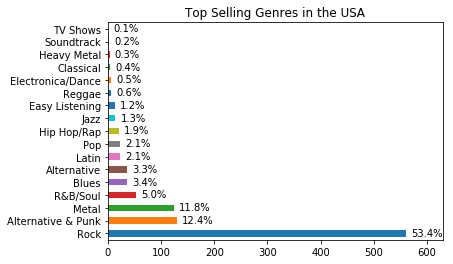

In [15]:
genre_sales_usa = run_query(usa_sales_by_genre)
genre_sales_usa.set_index("genre", inplace = True, drop = True)

genre_sales_usa["tracks_sold"].plot.barh(
    title = "Top Selling Genres in the USA",
    xlim = (0, 630),
    )

plt.ylabel("")

for i, label in enumerate(list(genre_sales_usa.index)):
    x_value = genre_sales_usa.loc[label, "tracks_sold"]
    label = round((genre_sales_usa.loc[label, "percentage_sold"] * 100), 1)
    plt.annotate(str(label) + "%", (x_value + 10, i - 0.2))
plt.show()

Wow, rock is by far the most popular, accounting for over 50% of the total sales in the US! The store should definitely be on the lookout for rock artists that they can sign and promote.

Looking at the genres of the artists we are choosing between, we can see that Punk is the most popular, then Blues, then Pop, and finally Hip-Hop. Based on this data alone, we would conclude that Red Tone and Slim Jim Bites are the best artists to promote, and Regal and Meteor & the Girls will likely be less successful. Still, if we had to choose 3, it would be Red Tone, Slim Jim Bites, and Meteor & the Girls.

### Analysing Employee Performance

Next, let's investigate the performance of some of our employees. Each of the Chinook store's customers gets assigned a sales support agent when they make their first purchase. We can look at those customers purchasing data to get a sense of how our employees are performing relative to one another.

Let's look at total sales in dollars of each sales support agent. Let's add their hire date to see if that has any impact on their total sales.

In [16]:
agent_sales_figures = '''
    SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(i.total) total_sales,
    e.hire_date
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    WHERE e.title = "Sales Support Agent"
    GROUP BY e.employee_id
    '''
run_query(agent_sales_figures)

,employee_name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


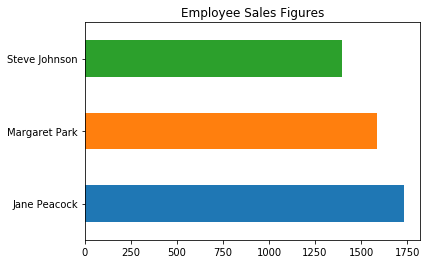

In [17]:
agents_sales = run_query(agent_sales_figures)
agents_sales.set_index("employee_name", inplace = True)

agents_sales["total_sales"].plot.barh(
    title = "Employee Sales Figures"
)
plt.ylabel("")
plt.show()

As suspected, the hire date is relevant to the total sales figures. The longer an employee has been working for Chinook, the higehr their total sales figures. With this in mind, Steve Johnson seems to be doing well compared to Margaret and Jane as, in the additional 5 months Margaret has been working, and the additional 6 months Jane has been working, they have only managed to sell slightly more than Steve.

Of course, to get a better sense of employee performance we'd need to know not just the hire date but also how long each employee had been working for Chinook. Unfortunately, we can't tell this for sure from the data.

We'd also need to know more about the assignment process and how customers' purchasing patterns are affected by the sales support agent. Since the sales support agent is assigned after the customer's first purchase, it could be the case that Steve happens to be assigned customers who make a substantial initial purchase but then never return, whereas Jane and Margaret are assigned customers that make small initial purchases, but who make frequent additional purchases thanks to the efforts of Jane and Margaret.

### Analysing Country Data

Now we'll analyse our data by country. We'll write a query that collates data on purchases from different countries, producing a DataFrame containing information on total number of customers, total value of sales, average value of sales per customer, and average order value, doing so for every country. We'll also add a group called "Other", in which we'll put all the results from countries with just one customer.

In [40]:
analysis_by_country = '''
    WITH customers_by_country AS
        (
         SELECT
             c.country,
             SUM(i.total) customer_total,
             COUNT (i.total) number_of_orders
         FROM customer c
         INNER JOIN invoice i ON i.customer_id = c.customer_id
         GROUP BY c.customer_id
         ORDER BY c.country
         )
    SELECT
        country,
        COUNT (*) total_customers,
        SUM(customer_total) total_sales,
        SUM(customer_total) / COUNT (*) sales_per_customer,
        SUM(customer_total) / SUM(number_of_orders) avg_order_value
    FROM customers_by_country
    GROUP BY country
    ORDER BY total_sales DESC
    '''
run_query(analysis_by_country)

,country,total_customers,total_sales,sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Ireland,1,114.84,114.840000,8.833846


We're nearly there, but our table is quite cluttered. We can sort it out by grouping countries with only one customer into the same category.

We can do this with the CASE clause. This clause will go through the conditions we provide, returning different results depending on whether the condition is met. These results are stored in a new column, the name of which we can specify after the END statement with END AS \[name\].

Here, we're using CASE to go through coutries and return the country as "Other" when there is only one customer, and returning the country name as normal if otherwise. We needn't worry about the number of customers being equal to zero in this case, as our database only stores information of customers it has made sales to, meaning the number of customers a country can have if it appears in our database is 1.

Once we've altered our country column to now contain "Other" values, we want to make sure this row appears in a desirable location on our table. We don't want to sort by total_sales and have "Other" appear at the top, because the whole point of sorting by total_sales is to identify the single country with the highest sales. Thus, we'll want to move "Other" to the bottom of our table.

We can do this by adding a new column which we'll use to sort out results before they're sorted by total_sales. We'll do this using CASE in much the same way as we did before by returning one result for countries equalling "Other" and another result to all other countries.

In [188]:
country_analysis = '''
    WITH customers_by_country AS
        (
         SELECT
             CASE
                 WHEN (
                       SELECT COUNT(*)
                       FROM customer
                       WHERE country = c.country
                       ) = 1 THEN "Other"
                 ELSE c.country
             END AS country,
             SUM(i.total) customer_total,
         COUNT (i.total) number_of_orders
         FROM customer c
         INNER JOIN invoice i ON i.customer_id = c.customer_id
         GROUP BY c.customer_id
         ORDER BY c.country
         )
    SELECT
        country,
        COUNT (*) total_customers,
        SUM(customer_total) total_sales,
        SUM(customer_total) / COUNT (*) money_spent_per_customer,
        SUM(customer_total) / SUM(number_of_orders) avg_order_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM customers_by_country
    GROUP BY country
    ORDER BY sort, total_sales DESC
    '''
run_query(country_analysis)

,country,total_customers,total_sales,money_spent_per_customer,avg_order_value,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


### Visualizing Country Data

The last thing we need to do is visualize our results. There's a lot of information in the above table which could be much more easily digested visually.

We'll visualize the information in each of the columns individually first.

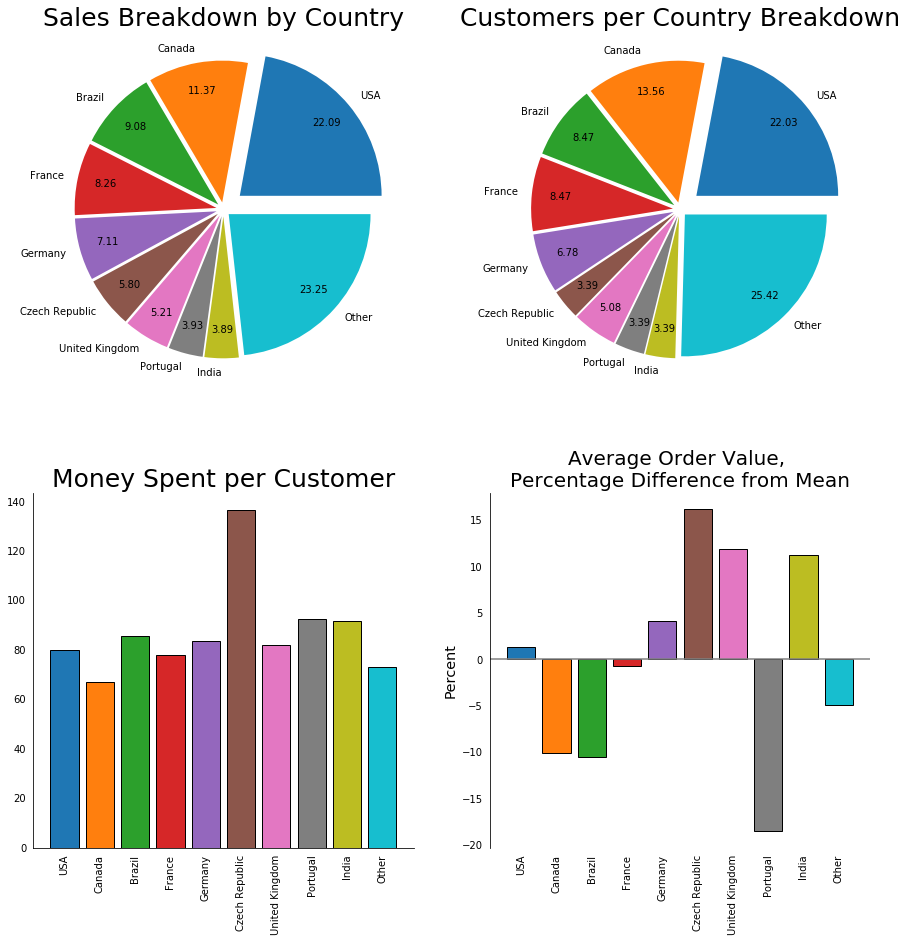

In [190]:
country_data = run_query(country_analysis)

fig, axes = plt.subplots(2, 2, figsize = (15, 15))
ax1 = axes[0, 0]
ax4 = axes[0, 1]
ax2 = axes[1, 0]
ax3 = axes[1, 1]

colors = [(31/255, 119/255, 180/255), (255/255, 127/255, 14/255), (44/255, 160/255, 44/255), (214/255, 39/255, 40/255), (148/255, 103/255, 189/255), (140/255, 86/255, 75/255), (227/255, 119/255, 194/255), (127/255, 127/255, 127/255), (188/255, 189/255, 34/255), (23/255, 190/255, 207/255)]

# Total Sales Data

ax1.pie(
    x = country_data["total_sales"],
    labels = country_data["country"],
    radius = 1,
    labeldistance = 1.1,
    autopct = "%.2f",
    pctdistance = 0.8,
    explode = [0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
)
ax1.set_title(
    "Sales Breakdown by Country",
    fontsize = 25,
    fontweight = 500,
)

# Sales per Customer Data

ax2.bar(
    x = country_data["country"],
    height = country_data["money_spent_per_customer"],
    color = colors,
    edgecolor = "black"
)
ax2.set_title(
    "Money Spent per Customer",
    fontsize = 25,
    fontweight = 500)
ax2.tick_params(bottom = False, top = False, right = False, left = False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation = 90)

# Comparing Average Order to the Mean

pct_diff_from_mean = ((country_data["avg_order_value"] - country_data["avg_order_value"].mean()) / country_data["avg_order_value"].mean()) * 100

ax3.bar(
    x = country_data["country"],
    height = pct_diff_from_mean,
    color = colors,
    edgecolor = "black"
)
ax3.set_ylabel("Percent")
ax3.set_title(
    "Average Order Value, \nPercentage Difference from Mean",
    fontsize = 20,
    fontweight = 500
)
ax3.axhline(y = 0, color = "gray")
ax3.tick_params(bottom = False, top = False, right = False, left = False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.spines["top"].set_visible(False)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation = 90)

plt.subplots_adjust(hspace = 0.3)

# Customers per Country

ax4.pie(
    x = country_data["total_customers"],
    labels = country_data["country"],
    radius = 1,
    labeldistance = 1.1,
    autopct = "%.2f",
    pctdistance = 0.8,
    explode = [0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
)
ax4.set_title(
    "Customers per Country Breakdown",
    fontsize = 25,
    fontweight = 500,
)

plt.show()

We can see from the above that the USA is, by a fairly large margin, Chinook's best market. However, it is interesting to note that US customers are unremarkable with regards to the amount they spend relative to other countries. Instead, it is customers from the Czech Republic that both spend the most individually and who have the highest order value. This indicates that it may be worth marketing more music to customers in the Czech Republic.

Customers from India and the United Kingdom also have a noticably high average order value relative to other countries. This may mean marketing to customers in those countries would be worthwhile. The money each customer from these countries spends is not that different from the average (unlike the Czech Republic), meaning there is likely fewer repeat purchases from these customers. A successful marketing campaign targeting these countries might therefore focus on increasing repeat custom.

### Analysing Purchase Types

Finally, we'll look at whether individuals tend to purchase whole albums or individual tracks. Chinook is interested in learning this as they may wish to stop purchasing albums to later sell and instead purchase only the most popular tracks from each album in order to save money.

This is made easier to analyse by the fact that the Chinook store does not allow customers to purchase whole albums and individual tracks, so we won't get any mixed orders. Customers can purchase each track on an album individually and then add additional individual tracks to their order, but these cases are rare enough that we need not be concerned with them here.

To answer our question, we need to know whether the track list on the invoice matches the track list on an album. We'll do this in several steps.
<br>
<br>
1. We'll make a table of the first_track_id of every invoice.
<br>
2. We'll use first_track_id to find all tracks that have the same album_id as the album_id of the first track of every invoice. This will create a table of all of the track_ids on a particular album.
<br>
3. We'll use first_track_id again to make another table which contains all of the track_ids on the invoice.
<br>
4. We now have a table of the track_ids for all of the tracks on an album, and a table of the track_ids for all of the tracks on an invoice. We can now compare them. Using the EXCEPT operator, we'll check everything in table 1 is in table 2. If it is, then the result will equal IS NULL. Then, we'll check everything in table 2 is in table 1. If it is, then the result will equal IS NULL. If the results of both checks are IS NULL, then our tables are the same, and we can conclude that the customer purchased an album. If the results of either or both checks is not NULL, then we can conclude that the customer purchased individual tracks.
<br>
5. Based on the results from our above checks, we'll create a boolean column with True or False values.
<br>
6. We'll count the number of rows in each of the groups, which will give us our final answer.

In [218]:
album_or_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ift.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     )

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     ) 
                 ) IS NULL
             THEN "True"
             ELSE "False"
         END AS "album_purchase"
     FROM invoice_first_track ift
    )
GROUP BY album_purchase;
'''

run_query(album_or_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


There we go! So we can see that the majority of Chinook's sales are of individual tracks. However, given the increased value of albums over tracks, it is likely that Chinook makes more money from album sales than from sales of individual tracks. Thus, Chinook should most likely continue to buy albums to sell, as their revenue from album sales is likely to be sufficiently high to justify the additional expense.